<a href="https://colab.research.google.com/github/CT-Cultures/Content/blob/master/RegOverview_Issue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Drive
import os
import sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# [1] Setting up Environment and Install Requirements

In [2]:
%%capture
!pip install -r sources/ChinaFilm/requirements.txt
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

!pip install transformers

In [3]:
# Load Module
import os
import gc
import pandas as pd
from bs4 import BeautifulSoup
import re
import datetime 

from IPython.display import display, HTML

import jieba.analyse
tfidf = jieba.analyse.extract_tags
textrank = jieba.analyse.textrank
import jieba.posseg as pseg

import torch

# Load Local Lib# Set Path
path_wd = '/content/drive/MyDrive/Github/Content'
os.chdir(path_wd)

from sources.NRTA.Record_Registration import Registration # assume relative path at path_wd

tv_reg = Registration()

In [4]:
# Set Path
path_records = '/content/drive/MyDrive/Github/Content/tools/articles/records'

## 1.3 Load Latest Registration Publication

In [11]:
os.chdir(path_wd + '/sources/NRTA')
!python Update_Registration.py

  File "Update_Registration.py", line 34
     ^
SyntaxError: invalid syntax


In [ ]:
os.chdir(path_wd + '/sources/NRTA')
##########################################

fp = '/content/drive/MyDrive/Github/Content/sources/NRTA/records/contents_of_registrations.json'
df = pd.read_json(fp)
curr_issue_dt = df.sort_values(['公示年月'], ascending=False)['公示年月'].iloc[0]
issue_name = str(curr_issue_dt)
issue_name

'2021年8月'

In [ ]:
# clean df, run mulitple times as necessary
df['许可证号'] = df['许可证号'].apply(lambda x:
                    x.lstrip('\n+').lstrip('\t+').lstrip('\w+').rstrip('\t+').rstrip('\n+'))
df['备注'] = df['备注'].apply(lambda x:
                    x.lstrip('\n+').lstrip('\t+').lstrip('\w+').rstrip('\t+').rstrip('\n+'))

In [ ]:
df_curr = df[df['公示年月'] == curr_issue_dt].copy()
print(df_curr.columns)

Index(['剧名', '集数', '报备机构', '题材', '内容提要', '公示年月', '许可证号', '体裁', '拍摄日期', '制作周期',
       '省级管理部门备案意见', '相关部门意见', '备注', '备案链接', '公示名称', '公示批次链接', '地区', '公示年'],
      dtype='object')


#[2] Load Model for Predictons


## [2.1] Extract top keywords

In [ ]:
df_curr['kw'] = df_curr['内容提要'].apply(textrank, topK=10)

In [ ]:
df_curr['kw'].to_numpy()

array([list(['外婆', '得到', '看到', '姨婆', '年轻人', '闺蜜', '日记', '风景', '遇到', '新旧']),
       list(['军号', '革命', '建设', '实行', '历史', '采用', '倒叙', '旱鸭子', '老烟', '将军']),
       list(['小叶', '海南', '全国', '大赛', '电机厂', '江洋', '木工', '参加', '学习', '技工']),
       list(['老师', '科技', '毕业', '宿舍', '音容', '昆心', '两人', '时代', '技术', '量子']),
       list(['村民', '文化', '国学', '支持', '传统', '问题', '大讲堂', '乡村', '上任', '梨花']),
       list(['辣椒', '产品', '召唤', '重返', '关珊', '理念', '继承', '振兴', '父辈', '推动']),
       list(['学生', '帮助', '老师', '奋斗', '走向', '可靠', '没有', '忘记', '走上', '高考']),
       list(['工作', '大院里', '真情', '继母', '待岗', '结了婚', '出版社', '迎来', '世间', '邻家']),
       list(['媳妇', '石头', '维持', '借钱', '打猎', '勉强', '生计', '重病', '撇下', '主人公']),
       list(['发展', '北苑', '经历', '老宅', '家宅', '村公所', '土改', '问题', '城乡差别', '生存']),
       list(['医术', '团队', '手术', '医疗', '患者', '急诊科', '医师', '帮助', '下入', '治疗']),
       list(['老张', '超市', '房间', '休闲', '购物', '经营', '下决心', '提供', '民宿', '成为']),
       list(['连生', '槐花', '宽恕', '要用', '弃婴', '化解', '遇到', '走上', '重病', '家庭']),
       list(

## [2.2] Load Title Prediction Model

In [ ]:
%%capture
from transformers import BertTokenizer, BartForConditionalGeneration

# assign device
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

# Instantiate tokenizer and model
checkpoint = "/content/drive/MyDrive/Github/Content/tools/models/PredTitle-10000"

tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = BartForConditionalGeneration.from_pretrained(checkpoint)
model.to(device)
model.eval()

In [ ]:
batch_size = 8
i = 0
ls = df_curr['内容提要'].tolist()
L = df_curr.shape[0]
test_predictions = []

while i < L:
  inputs = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  inputs.to(device)
  summary_ids = model.generate(input_ids=inputs['input_ids'],
                             num_beams=4,
                             min_length=0,
                             max_length=32
                             )
  
  ret = [tokenizer.decode(g, 
                         skip_specical_tokens=True, 
                         clean_up_tokenization_spaces=True) for g in summary_ids]
  test_predictions.extend(ret)
  i += batch_size

In [ ]:
df_curr['预测剧名'] = test_predictions

def remove_specials(x):
  x = re.sub(' ', '', x)
  x = re.sub('\[CLS\]', '', x)
  x = re.sub('\[PAD\]', '', x)
  x = re.sub('\[SEP\]', '', x)
  x = re.sub('\[UNK\]', '', x)
  return x

df_curr['预测剧名'] = df_curr['预测剧名'].apply(remove_specials)

In [ ]:
df_curr['预测剧名'].to_numpy()

array(['外婆的日记', '军号', '开车的女人', '大学老师', '梨花节', '红色的地毯', '青春的守护者', '四合院',
       '老石头', '北苑的故事', '天才医生', '吉祥胡同', '槐花开', '小家', '我们的初恋', '高家沟',
       '北雅医生', '幸福不是梦', '雄安之恋', '小胜利', '我们的幸福生活', '红军长征', '烽火英雄', '红河传奇',
       '金牌保代', '青山绿水青山', '急诊四杰', '家在福州', '好日子好日子', '茶香', '实习律师', '房车店',
       '越今朝', '茉莉花开', '青山绿水', '我的厨房老板', '外来媳妇本地郎', '欢喜客栈', '缉毒警花'],
      dtype=object)

## [2.3] 识别主要角色

In [ ]:
df_curr['time'] = df_curr['题材'].apply(lambda x: x[0:2])
df_curr['genre'] = df_curr['题材'].apply(lambda x: x[2:])

df_curr['制作周期_月'] = df_curr['制作周期'].apply(lambda x: int(x.rstrip('个月')))

def months_to_principal_photography(x: pd.Series):
  year = int(x.split('.')[0])
  month = int(x.split('.')[1])
  now = datetime.datetime.now()
  p_date = datetime.date(year, month, 15)
  months_from_now = (p_date - now.date()).days // 30
  return months_from_now

df_curr['距离开机'] = df_curr['拍摄日期'].apply(months_to_principal_photography)
df_curr['预估拍摄速度'] = df_curr['制作周期_月'] / df_curr['集数']*30

In [ ]:
import jieba
import jieba.posseg as pseg
jieba.enable_paddle() #启动paddle模式。 0.40版之后开始支持，早期版本不支持

Paddle enabled successfully......


In [ ]:
# 识别主要角色
def find_PER(x: pd.Series):
  words = pseg.cut(x, use_paddle=True)
  ls_PER = []
  for word, flag in words:
    if flag == 'PER':
      word = word.strip('[\s,，。、“”？；]')
      ls_PER.append(word)
  ls_PER = list(set(ls_PER))

  ls_PER1 = ls_PER.copy()
  ls_PER = []
  while ls_PER1:
    PER =  ls_PER1.pop(0)
    ls_tmp = re.split('[\s,，。、“”？；]', PER)
    ls_PER.extend(ls_tmp)

  ls_PER = list(set(ls_PER)) 
  ls_PER = [PER for PER in ls_PER if len(PER) > 1]
  ls_PER_sorted = sorted(ls_PER, reverse=False, key=lambda x: len(x))

  ans = []
  while ls_PER_sorted:
    PER = ls_PER_sorted.pop(0)
    i = 0
    while i < len(ls_PER_sorted):
      if re.search(PER, ls_PER_sorted[i]):
        ls_PER_sorted.pop(i)
        ans.append(PER)
      i += 1
    if PER not in ans:
      ans.append(PER)

  return ans

df_curr['主要角色'] = df_curr['内容提要'].apply(find_PER)

In [ ]:
df_curr['主要角色'].to_numpy()

array([list(['郭绮', '孙淑芳', '孙淑兰']),
       list(['韩栋', '小秀', '刘启民', '陈占喜', '沈国放', '韩文斌']),
       list(['林放', '孙革', '朱巧', '梁超', '吕小叶', '朱秋生', '林发祥']),
       list(['女娲', '王昆', '玄英']), list(['孟乃文']),
       list(['关珊', '李世钧', '李向荣', '李欣欣', '陆士敏']), list(['宛秋', '苗老师']),
       list(['周扬', '丁文白']), list([]), list(['赵家因', '赵子午', '马出奇']),
       list(['林渊', '贺前', '苏云', '郑仁', '常悦', '潘主任', '谢伊人', '鲁道夫']),
       list(['老张', '张西西']), list(['二宝', '连生', '张亦心']),
       list(['平公', '大梁', '尹萌萌']), list(['鹿芃']), list(['加林', '巧珍', '黄亚萍']),
       list(['宁至谦', '阮流筝']), list(['尚可', '李秀娟', '王大天', '陈二万']),
       list(['雄安', '林红', '程颂卿', '郑培德', '刘子鸣']),
       list(['罗春', '蔡海华', '杨钱树']),
       list(['姐姐', '宋晴', '易玲', '宋晴雅', '知书达理']),
       list(['周励', '李乐山', '辜凌森', '辜丽君']),
       list(['许配', '刘爱梅', '马守勤', '刘团长']), list(['梁如玉', '杨景林', '许平昌']),
       list(['任炎', '楚千淼']), list(['许家', '郑本坤', '许嘉富']),
       list(['刘非', '王扬']), list(['罗林', '杨威', '罗天明', '林家荫', '肖玉莲', '林家成']),
       list(['栗洁', '高小云', '马若谷

# [2] Generating Article Contents

##[2.1] 2021年X月电视剧备案划重点

In [ ]:
# Title
T1 = '{}电视剧备案划重点'.format(df_curr['公示年月'].iloc[0])

print(T1)

2021年8月电视剧备案划重点


In [ ]:
dfview = df_curr[[
                   '剧名', '集数', '距离开机', 'genre', 
                   'time', '主要角色', '报备机构', '内容提要',
                   '预测剧名', 'kw']].sort_values('距离开机')
dfview.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 12457 to 12442
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   剧名      39 non-null     object
 1   集数      39 non-null     int64 
 2   距离开机    39 non-null     int64 
 3   genre   39 non-null     object
 4   time    39 non-null     object
 5   主要角色    39 non-null     object
 6   报备机构    39 non-null     object
 7   内容提要    39 non-null     object
 8   预测剧名    39 non-null     object
 9   kw      39 non-null     object
dtypes: int64(2), object(8)
memory usage: 3.4+ KB


In [ ]:
# WIP
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path_font = '/content/drive/MyDrive/Github/Content/tools/articles/fonts/simhei.ttf'
font = fm.FontProperties(fname=path_font)  # speicify font
%matplotlib inline


dfview.groupby('genre')['genre'].count().plot(kind='pie')

ax = dfview.groupby('genre')['genre'].count().plot(kind='pie')
ax.set_label(font=font)

##[2.2] 	本期通过备案的电视剧共计39部,估计已开机的1部,一个月内将开机的20部,距离开机一个月以上的18部。其中，20集(含）以下的电视剧又4部,20到40集的有35部,超过40集的有0部。


In [ ]:
dfview.columns

Index(['剧名', '集数', '距离开机', 'genre', 'time', '主要角色', '报备机构', '内容提要', '预测剧名',
       'kw'],
      dtype='object')

In [ ]:
# Write Content
T2 = '\n'
T2 += '本期通过备案的电视剧共计{}部，'.format(dfview.shape[0])
T2 += '估计已开机的{}部，'.format(dfview[dfview['距离开机'] < 0].shape[0])
T2 += '一个月内将开机的{}部，'.format(
    dfview[(dfview['距离开机'] >= 0) & (dfview['距离开机'] < 2)].shape[0])

T2 += '距离开机一个月以上的{}部。'.format(
    dfview[(dfview['距离开机'] > 2)].shape[0])

T2 += '其中，20集(含）以下的电视剧有{}部，'.format(dfview[dfview['集数'] <= 20].shape[0])
T2 += '20到40集的有{}部，'.format(
    dfview[(dfview['集数'] > 20) & (dfview['集数'] <= 40)].shape[0])
T2 += '超过40集的有{}部。'.format(dfview[dfview['集数'] > 40].shape[0])

print(T2)


本期通过备案的电视剧共计39部，估计已开机的1部，一个月内将开机的20部，距离开机一个月以上的18部。其中，20集(含）以下的电视剧有4部，20到40集的有35部，超过40集的有0部。


##[2.3] 	本批次中，大数据分析识别出XX部上市影视公司关联项目，占比XX%。慷田AI聚焦关注的有

In [ ]:
# 本批次中与上市影视公司关联的项目有
info_public_film_co = pd.read_csv('/content/drive/MyDrive/Github/Content/tools/articles/reference/info_public_film_co.csv', index_col=0, encoding='utf-8-sig')
ls = info_public_film_co['公司简称'].apply(eval).sum()
pat_public = '|'.join(ls)
pat_public += '|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店|华策|电视剧制作中心'
pat_public += '|得闲|芒果|新丽|欢乐|尚世|华策|稻草熊|东阳欢娱|耀客|湖南快乐阳光|山东影视制作|当代时光'
pat_public += ''
df_focus = dfview.loc[dfview['报备机构'].str.contains(pat_public), :]
df_focus[['剧名','报备机构', '集数','内容提要', 'genre']]

,剧名,报备机构,集数,内容提要,genre
12430,听说你喜欢我,上海耀客传媒股份有限公司,40,阮流筝离家七年后回到了自己生长的城市，成为北雅医院神经外科的一名进修医生。为了能留在北雅，阮...,都市
12431,人生·路遥,上海当代时光文化传媒有限公司,40,八十年代，生活在陕北高家沟的青年高加林打小就是村里人人皆知的读书“状元”。虽然家境贫寒，但他...,其它
12453,陪你一起好好吃饭,湖南快乐阳光互动娱乐传媒有限公司,16,生鲜平台老板余昊为推广自己的公司赞助并参加美食节目，却为节省时间，在节目上使用替身进行菜品制...,都市
12462,实习律师,新丽电视文化投资有限公司,40,潘岩是荣柯律所的实习律师，他和同期进入荣柯实习的舒一南、左娜、祝欣欣相继遇到了初入职场的困惑...,都市
12432,向前一步,上海耀客传媒股份有限公司,40,鹿芃是一个年轻的当代女性，情人节这一天，有三个男人向鹿芃发出了约会邀请,都市
12456,祈今朝,山东影视制作股份有限公司,36,小镇青年越今朝携义妹越祈闯荡江湖多年，一次偶然的机会，他们与洛家少主洛昭言不打不相识，意外得...,传奇
12428,雄安之恋,河北电影电视剧制作中心,40,来自深圳的绿色建筑倡导者林红，在雄安新区成立次日就来到了雄安。交通设计行业的权威程颂卿刚刚离...,都市
12440,老邻居,寰亚耀智影视文化（北京）有限公司,40,1980年，参加工作并结了婚的丁文白回到久违的四合院，与父亲和继母住在同一屋檐下。大院里住着...,都市


In [ ]:
df_focus_narrowed['单位简称'] = df_focus_narrowed['报备机构'].str.extract('('+ pat_public + ")")

In [ ]:
df_focus_narrowed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 12430 to 12440
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   剧名       7 non-null      object
 1   集数       7 non-null      int64 
 2   距离开机     7 non-null      int64 
 3   genre    7 non-null      object
 4   time     7 non-null      object
 5   主要角色     7 non-null      object
 6   报备机构     7 non-null      object
 7   内容提要     7 non-null      object
 8   预测剧名     7 non-null      object
 9   kw       7 non-null      object
 10  单位简称     7 non-null      object
 11  src_img  0 non-null      object
 12  tgt_img  7 non-null      object
dtypes: int64(2), object(11)
memory usage: 1.1+ KB


In [ ]:
ids = [12430,12431,12453,12462,12432,12456,12440]
df_focus_narrowed = df_focus_narrowed.loc[ids]

########
T3 = '\n'
T3 += '本批次中，大数据分析识别出{}部上市影视公司关联项目，'.format(df_focus.shape[0])
T3 += '占比{}%。'.format(round((df_focus.shape[0]/df_curr.shape[0]*100),2))
T3 += '结合题材与出品方实力，慷田AI聚焦关注的有'

for i, row in df_focus_narrowed.iterrows():
  T3 += '{}的'.format(row['单位简称'])
  if i == df_focus_narrowed.index[-2]:
    T3 += '《{}》和'.format(row['剧名'])
  else:
    T3 += '《{}》、'.format(row['剧名'])
T3 = T3.rstrip('、') + '，'

T3 += '题材类型包括了{}。\n'.format(
    '、'.join(df_focus_narrowed['genre'].unique())
)
print(T3)


本批次中，大数据分析识别出8部上市影视公司关联项目，占比20.51%。结合题材与出品方实力，慷田AI聚焦关注的有耀客的《听说你喜欢我》、当代的《人生·路遥》、湖南快乐阳光的《陪你一起好好吃饭》、新丽的《实习律师》、耀客的《向前一步》、山东影视制作的《祈今朝》和寰亚的《老邻居》，题材类型包括了都市、其它、传奇。



In [ ]:
df_focus_narrowed.index[-2]

12456

## [2.4] 生成词云图

In [ ]:
df_focus_narrowed.index

Int64Index([12430, 12431, 12453, 12462, 12432, 12456, 12440], dtype='int64')

In [ ]:
import wordcloud
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


path_font = '/content/drive/MyDrive/Github/Content/tools/articles/fonts/STHUPO.TTF'
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'

def generate_word_image(ls_words, img_name):
  path_genre_icon = path_img + '/genre_icon/{}'.format(img_name)
  path_mask_image = path_img + '/genre_icon/mask_{}'.format(img_name)
  path_color_image = path_img + '/genre_icon/{}'.format(img_name)

  #wordcloud.color_from_image(coloring)
  mask = np.array(Image.open(path_mask_image)) # 定义词频背景
  coloring = np.array(Image.open(path_color_image)) # Load Image for coloring
  image_colors = wordcloud.ImageColorGenerator(coloring, default_color=(79, 46, 47))
  #image_colors = wordcloud.ImageColorGenerator(coloring)
  #wc.recolor(color_func=image_colors,  random_state=3)

  wc = wordcloud.WordCloud(
      font_path=path_font,
      width = 400,
      height = 100,
      scale = 1,
      mask=mask, # set back ground mask image
      max_words=188,
      max_font_size=244,
      min_font_size=4,
      mode="RGBA",
      #mode="RGB",
      background_color=None, 
      #background_color="rgba(255, 255, 255, 0)", 
      #contour_width=3, 
      #contour_color='steelblue',
      repeat=True,
      color_func=image_colors,
  )
  wc.generate(','.join(ls_words))


  plt.imshow(wc) # 显示词云
  plt.axis('off') # 关闭坐标轴
  plt.show()

  fp_generated_img = path_img + '/TVreg_'  \
             + img_name.split('.')[0] + '_' \
             + ls_words[0] + '_' + issue_name + '.png'
  wc.to_file(fp_generated_img)

  return fp_generated_img


In [ ]:
df_label2image = pd .read_json(path_records + '/df_label2image.json')
#df_label2image.to_json(path_records + '/df_label2image.json')
df_label2image.loc[61, 'fn'] ='city-48851_1280.png'
df_label2image.loc[64, 'fn'] = 'buffalo-5909131.png'
df_label2image.tail(13)

,label,fn
52,传奇,fu-4075734_1920.png
53,传记,lampion-1509664_1920.png
54,军旅,explosion.png
55,农村,buffalo-5909131.png
56,宫廷,woman-6032953_1920.png
57,武打,fighter-2732203_1920.png
58,涉案,jail.png
59,神话,mermaid-5030505_1920.png
60,科幻,jupiter-55000.png
61,都市,city-48851_1280.png


In [ ]:
df_focus_narrowed['src_img'] = None
df_focus_narrowed['tgt_img'] = None

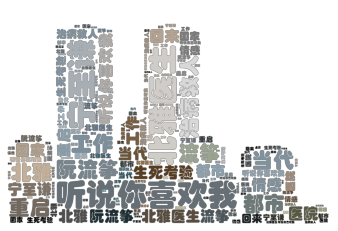

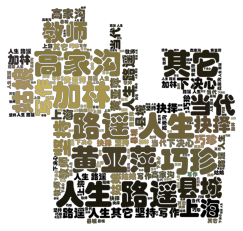

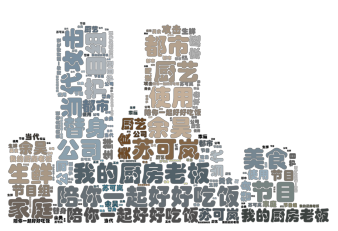

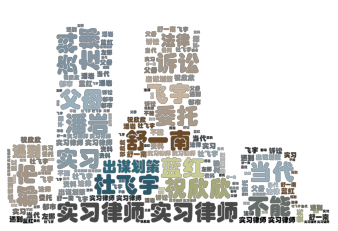

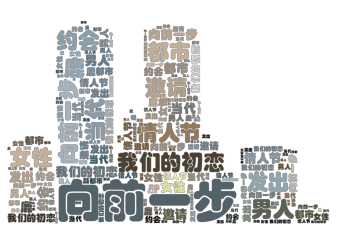

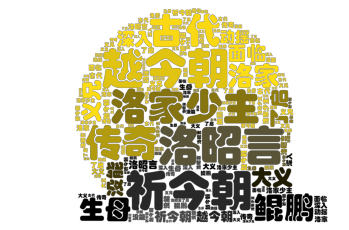

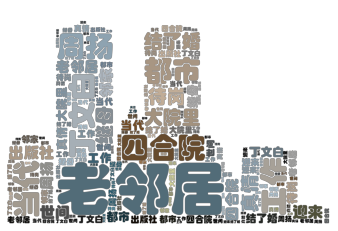

In [ ]:
for i in df_focus_narrowed.index:
  ls = [df_focus_narrowed.loc[i, '剧名']] * 10
  ls += [df_focus_narrowed.loc[i, '预测剧名']] *6
  ls += df_focus_narrowed.loc[i, '主要角色']*3
  ls += [df_focus_narrowed.loc[i, 'genre']] *3
  ls += [df_focus_narrowed.loc[i, 'time']]*3
  ls += df_focus_narrowed.loc[i, 'kw']
  img_fn = df_focus_narrowed.loc[i, 'src_img']
  if not img_fn:
    img_fn = df_label2image.loc[
        df_label2image['label'] == df_focus_narrowed.loc[i, 'genre'],
        'fn'
    ].iloc[0]
  fp_generated_img = generate_word_image(ls, img_fn)
  df_focus_narrowed.loc[i, 'tgt_img'] = fp_generated_img

##[2.5] 生成摘要

In [ ]:
S0 = issue_name
S0 += '电视剧备案慷田AI聚焦关注的有'

for i, row in df_focus_narrowed.iterrows():
  S0 += '{}的'.format(row['单位简称'])
  if i == df_focus_narrowed.index[-2]:
    S0 += '《{}》和'.format(row['剧名'])
  else:
    S0 += '《{}》、'.format(row['剧名'])
S0 = S0.rstrip('、') + '，'

S0 += '题材类型包括了{}。\n'.format(
    '、'.join(df_focus_narrowed['genre'].unique())
)
print(S0)

2021年8月电视剧备案慷田AI聚焦关注的有耀客的《听说你喜欢我》、当代的《人生·路遥》、湖南快乐阳光的《陪你一起好好吃饭》、新丽的《实习律师》、耀客的《向前一步》、山东影视制作的《祈今朝》和寰亚的《老邻居》，题材类型包括了都市、其它、传奇。



##[2.6] 指向国家广电局官网


In [ ]:
#####
T6 = '\n\n'
T6 += '慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。'
T6 += '电影立项备案公示信息来自国家广播电视总局 National Radio and Televison Administration, 官方网址 '
T6 += ' http://www.nrta.gov.cn/ 。'

print(T6)



慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。电影立项备案公示信息来自国家广播电视总局 National Radio and Televison Administration, 官方网址  http://www.nrta.gov.cn/ 。


In [ ]:
issue_name

'2021年8月'

## [2.7] Save df of this issue pickle

In [ ]:
df_curr.to_pickle(path_records + '/df_tvreg_{}.pkl'.format(issue_name))
df_focus_narrowed.to_pickle(path_records + '/df_tvreg_focus_{}.pkl'.format(issue_name))

In [ ]:
df_curr = pd.read_pickle(path_records + '/df_tvreg_{}.pkl'.format(issue_name))
df_focus_narrowed = pd.read_pickle(path_records + '/df_tvreg_focus_{}.pkl'.format(issue_name))

#[3] Output Word Document

## 3.1 Install and Load Libraries

In [ ]:
%%capture
!pip install python-docx
!pip install lxml
from docx import Document
from docx.shared import Inches
#from docx.text.parargaph import Paragraph

In [ ]:
df_focus_narrowed[['报备机构']]

,报备机构
12430,上海耀客传媒股份有限公司
12431,上海当代时光文化传媒有限公司
12453,湖南快乐阳光互动娱乐传媒有限公司
12462,新丽电视文化投资有限公司
12432,上海耀客传媒股份有限公司
12456,山东影视制作股份有限公司
12440,寰亚耀智影视文化（北京）有限公司


## 3.2 Output Docx


In [ ]:
path_doc = '/content/drive/MyDrive/Github/Content/tools/articles/docx'
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'

doc = Document()
doc.core_properties.title = 'China TV Registration Overview ' + issue_name

doc.add_heading(T1, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

doc.add_paragraph(T2)
doc.add_paragraph(T3)

for i, row in df_focus_narrowed.iterrows():
  if  row['距离开机'] <= 0: pstatus = '估摸着已开机'
  elif  0 < row['距离开机'] <= 1: pstatus = '预计一个月内开机'
  else: pstatus = '预计距离开机1个月以上' 
  txt = '《{}》，{}集，{}。'.format(row['剧名'], row['集数'], pstatus)
  txt += '\n报备机构：{}'.format(row['报备机构'])
  txt += '\n主要角色：{}'.format('、'.join(row['主要角色']))
  doc.add_paragraph(txt)

  doc.add_picture(row['tgt_img'], width =Inches(4))

table = doc.add_table(rows=1, cols=1, style='Light List Accent 3')
i = 1
for _, row in dfview.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[{}] '.format(i) + \
                      '《{}》，'.format(row['剧名']) + \
                      '{}集'.format(row['集数'])

  #if row['匹配片名'] != '':
  #  row_cells[0].text += ' (原备案名《{}》)'.format(row['匹配片名'])

  row_cells = table.add_row().cells
  row_cells[0].text = row['time'] + row['genre']
  
  if  row['距离开机'] <= 0: pstatus = '估摸着已开机'
  elif  0 < row['距离开机'] <= 1: pstatus = '预计一个月内开机'
  else: pstatus = '预计{}个月后开机'.format(row['距离开机'])
  row_cells = table.add_row().cells
  row_cells[0].text = pstatus
  #if row['是否修改'] == '是':
  #  row_cells[0].text += ', 修改后通过备案'

  row_cells = table.add_row().cells
  row_cells[0].text = '报备机构: {}'.format(row['报备机构'])

  row_cells = table.add_row().cells
  row_cells[0].text = '主要角色: {}'.format('、'.join(row['主要角色']))

  row_cells = table.add_row().cells
  row_cells[0].text = ''
  i+=1

doc.add_paragraph(T6)

doc.save(path_doc + '/TVregOverview_' + issue_name + '.docx' )
